In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-11-02 09:56:15.062830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762077375.282372      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762077375.336856      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"

train_dir = dataset_dir + "/train"
test_dir = dataset_dir + "/test"

print("Dataset train path:", train_dir)
print("Dataset test path:", test_dir)

Dataset train path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train
Dataset test path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/test


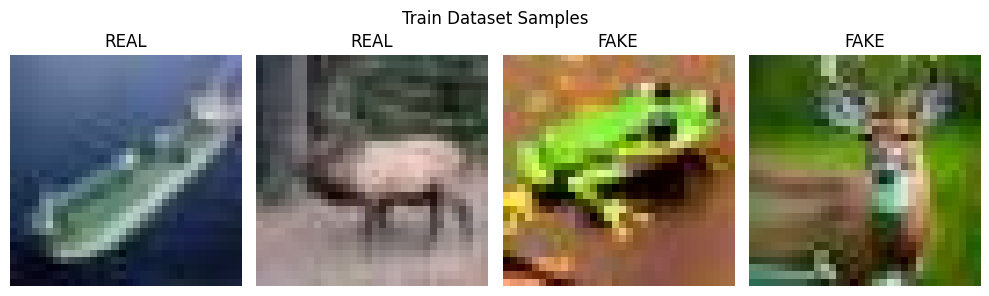

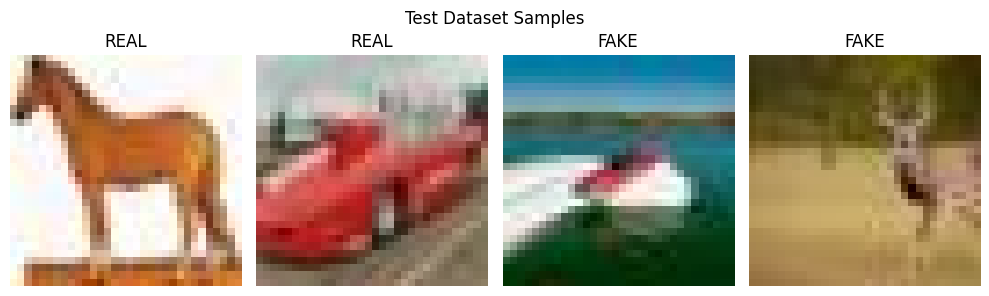

In [3]:
# Ambil beberapa contoh file dari masing-masing kelas
classes = ['REAL', 'FAKE']

def show_examples(base_dir, title):
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    fig.suptitle(title, fontsize=12)

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, cls)
        sample_files = random.sample(os.listdir(cls_dir), 2)
        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(cls_dir, img_name)
            img = mpimg.imread(img_path)
            ax = axes[i*2 + j]
            ax.imshow(img)
            ax.set_title(f"{cls}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan contoh dari train dan test
show_examples(train_dir, "Train Dataset Samples")
show_examples(test_dir, "Test Dataset Samples")

In [4]:
img_height = 32
img_width = 32
batch_size = 64
seed = 42

#load data folder train
full_train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

#Split 90% train dan 10% val
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
val_batches = int(total_batches * 0.1)
train_batches = total_batches - val_batches

train_ds = full_train_ds.take(train_batches)
val_ds = full_train_ds.skip(train_batches)

#Load data test dari folder test (tidak diubah atau diacak)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

#Optimasi pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

def count_images(dataset):
    return sum(batch[0].shape[0] for batch in dataset)

train_count = count_images(train_ds)
val_count = count_images(val_ds)
test_count = count_images(test_ds)

print("Dataset summary:")
print(f"Total batch di folder train: {total_batches}")
print(f"Train batches (90%): {train_batches}")
print(f"Validation batches (10%): {val_batches}")
print(f"Jumlah gambar:")
print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Found 100000 files belonging to 2 classes.


I0000 00:00:1762077518.369005      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 20000 files belonging to 2 classes.
Dataset summary:
Total batch di folder train: 1563
Train batches (90%): 1407
Validation batches (10%): 156
Jumlah gambar:
Train images: 90048
Validation images: 9952
Test images: 20000


In [5]:
# Augmentasi Data (Train Saja)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

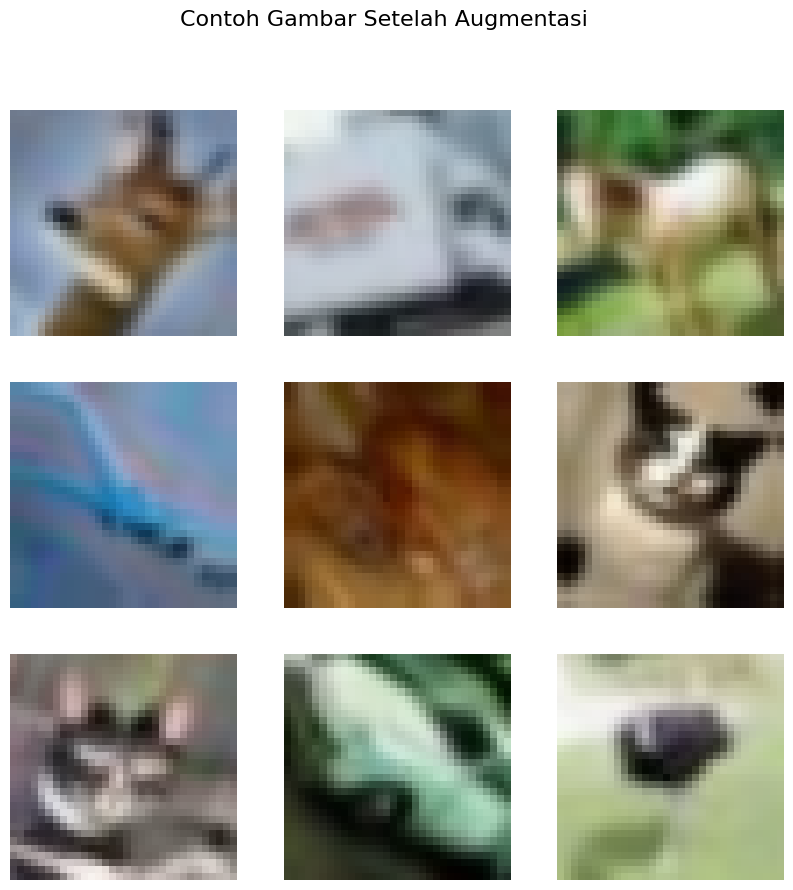

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented = data_augmentation(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(tf.cast(augmented[i], tf.uint8))  # pakai uint8 biar warna asli
        plt.axis("off")
    plt.suptitle("Contoh Gambar Setelah Augmentasi", fontsize=16)
    plt.show()

In [7]:
# Normalisasi untuk semua
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# ResNet101 (tanpa pretrained weights)
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights=None,
    input_shape=(img_height, img_width, 3),
    pooling='avg'
)

base_model.trainable = True

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,207,425 (164.82 MB)

 Trainable params: 43,097,985 (164.41 MB)

 Non-trainable params: 109,440 (427.50 KB)

In [9]:
# Training dengan EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20


I0000 00:00:1762077826.192439      64 service.cc:148] XLA service 0x1dd602a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762077826.193385      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762077835.518693      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1407 ━━━━━━━━━━━━━━━━━━━━ 51:38:02 132s/step - accuracy: 0.5156 - loss: 5.3562 - precision: 0.4286 - recall: 0.3214

I0000 00:00:1762077861.678047      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 238s 75ms/step - accuracy: 0.7087 - loss: 1.4122 - precision: 0.7115 - recall: 0.6996 - val_accuracy: 0.7966 - val_loss: 0.4780 - val_precision: 0.9419 - val_recall: 0.6256
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - accuracy: 0.8354 - loss: 0.4071 - precision: 0.8337 - recall: 0.8381 - val_accuracy: 0.8399 - val_loss: 0.4272 - val_precision: 0.9332 - val_recall: 0.7270
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.8589 - loss: 0.3398 - precision: 0.8550 - recall: 0.8644 - val_accuracy: 0.6798 - val_loss: 0.6552 - val_precision: 0.9399 - val_recall: 0.3736
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.8691 - loss: 0.3291 - precision: 0.8676 - recall: 0.8730 - val_accuracy: 0.7108 - val_loss: 1.2600 - val_precision: 0.9751 - val_recall: 0.4236
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.8772 - loss: 0.3227 - precision: 0.8729 - recall: 0.8835 - val_accuracy: 0.8721 - va

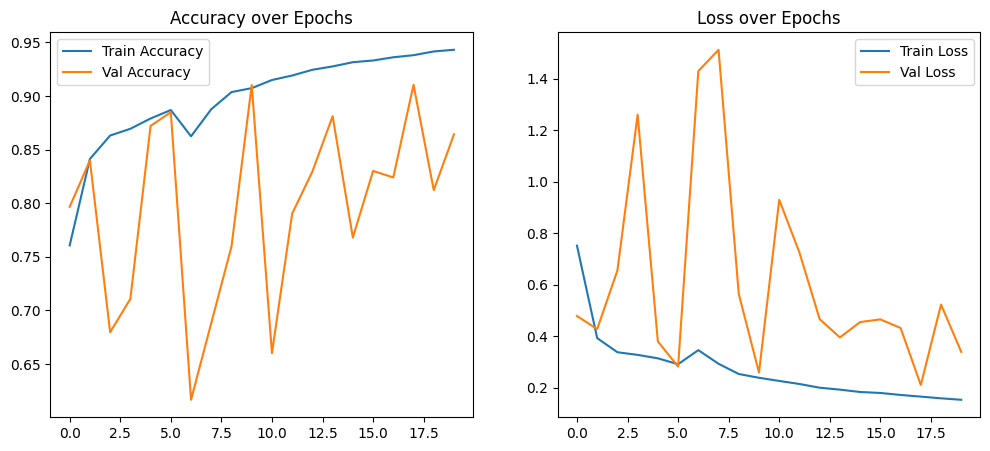

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9581 - loss: 0.1197 - precision: 0.4617 - recall: 0.4182

Test Accuracy: 0.9063
Test Precision: 0.9782
Test Recall: 0.8311
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step


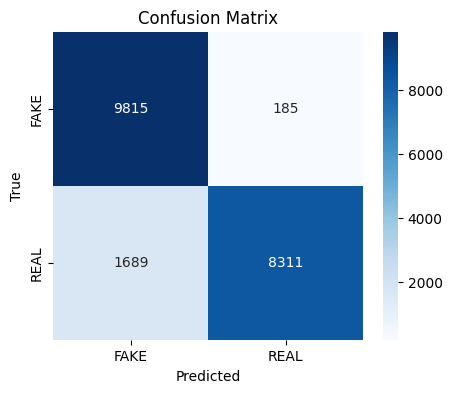


Classification Report:
              precision    recall  f1-score   support

        FAKE       0.85      0.98      0.91     10000
        REAL       0.98      0.83      0.90     10000

    accuracy                           0.91     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       0.92      0.91      0.91     20000



In [11]:
# 11️Evaluasi di Data Test
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['FAKE', 'REAL']))